In [1]:
import pandas as pd
from datasets import load_dataset, concatenate_datasets
from matplotlib import pyplot as plt

Reading the raw dataset.

In [2]:
ds = load_dataset(
    "mlburnham/polistance_issue_tweets",
    revision="fa7d01a3ab1a2e563506f0b5d422b394d975a8d9"
)
df = concatenate_datasets(ds.values()).to_pandas()
df

README.md:   0%|          | 0.00/857 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/163k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10087 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1242 [00:00<?, ? examples/s]

,username,premise,party,topic,hypothesis,label,validated_label,entailment,validation_source
0,SenBobCasey,My heart also breaks for the families who have...,Democrat,gun control,The author of this text opposes gun control.,1,1,1,human
1,SenTedCruz,The objective of the Democrats radical gun con...,Republican,gun control,The author of this text opposes gun control.,2,2,0,human
2,SenTedCruz,"The fact is, Democrats don't want Americans to...",Republican,gun control,The author of this text opposes gun control.,2,2,0,human
3,SenFeinstein,President Biden has done what he can by execut...,Democrat,gun control,The author of this text supports gun control.,1,1,0,gpt-4o-2024-05-13
4,SenBlumenthal,Emergency red flag lawscourt orders that enabl...,Democrat,gun control,The author of this text opposes gun control.,1,1,1,human
...,...,...,...,...,...,...,...,...,...
11324,RepLoriTrahan,"In 2021, 4 MILLION children nationwide were li...",Democrat,the Child Tax Credit or CTC,The author of this text opposes the child tax ...,1,1,1,gpt-4o-2024-05-13
11325,RepDavidTrone,The expanded Child Tax Credit lifted 5.3 milli...,Democrat,the Child Tax Credit or CTC,The author of this text opposes the child tax ...,1,1,1,gpt-4o-2024-05-13
11326,RepJasonSmith,Washington Democrats have broken the Child Tax...,Republican,the Child Tax Credit or CTC,The author of this text supports the child tax...,2,2,1,gpt-4o-2024-05-13
11327,RepJasonSmith,Democrats took the Child Tax Credit &amp; turn...,Republican,the Child Tax Credit or CTC,The author of this text supports the child tax...,2,2,1,gpt-4o-2024-05-13


Dropping useless columns.

In [3]:
df = df.drop(columns=["username", "party", "topic", "hypothesis", "label", "entailment", "validation_source"])

Renaming columns.

In [4]:
df = df.rename(columns={"premise": "body", "validated_label": "leaning"})

Categorizing the leaning column.

In [5]:
df["leaning"].unique()

array([1, 2])

In [6]:
df["leaning"] = df["leaning"].replace({1: "left", 2: "right"})
df["leaning"] = df["leaning"].astype("category")

Dropping rows with missing data.

In [7]:
df = df.dropna()

Printing duplicates.

In [8]:
df[df["body"].duplicated(keep=False)]

,body,leaning
55,Raising the minimum wage. Protecting voting ri...,left
60,This is no surprise. The filibuster rule enabl...,left
137,Getting rid of the filibuster isnt just about ...,left
254,End the filibuster and protect voting rights. ...,left
257,PresidentBidens failed border policiesreach al...,right
...,...,...
10867,"While the very rich get richer, working class ...",left
11031,Our work to expand the #ChildTaxCredit is alre...,left
11075,"Monday, November , is the last day for eligibl...",left
11129,"TODAY, NOVEMBER , is the *LAST* day for eligib...",left


Dropping the duplicates.

In [9]:
df = df.drop_duplicates(subset="body")

Inspecting body length.

In [10]:
df["body_length"] = df["body"].str.len()
df["body_word_count"] = df["body"].str.split().str.len()
df = df.sort_values(by="body_length")
df.head()

,body,leaning,body_length,body_word_count
496,#NAME?,left,6,1
1629,BANS OFF OUR GUNS,right,17,4
3407,Abortion is murder.,right,19,3
2861,#AbortionIsHealthcare,left,21,1
3166,Abortion is Healthcare.,left,23,3


After inspection, articles with bodies shorter than 2 words seem to contain no political value. Removing them.

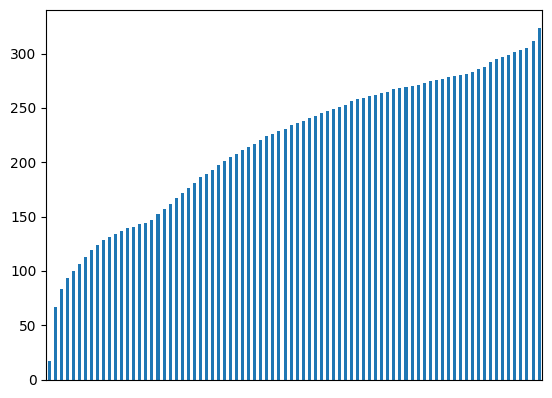

In [11]:
body_word_count_lower_bound = 2
df = df[df["body_word_count"] >= body_word_count_lower_bound]
# Ensuring to include the last (longest) item.
downsampled = pd.concat([df["body_length"].iloc[::100], df["body_length"].tail(1)]).drop_duplicates()
downsampled.plot.bar().xaxis.set_ticks([]);

In [12]:
df["body_length"].mean()

np.float64(197.05781584582442)

The leaning distribution.

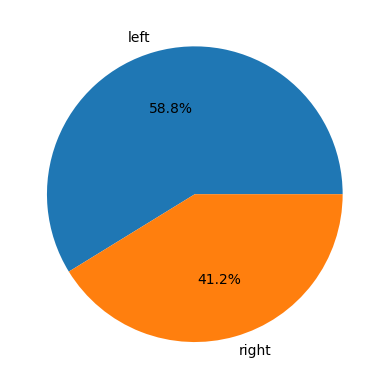

In [13]:
df.groupby("leaning", observed=True).size().plot.pie(autopct="%1.1f%%");

The distribution of body length sums per leaning.

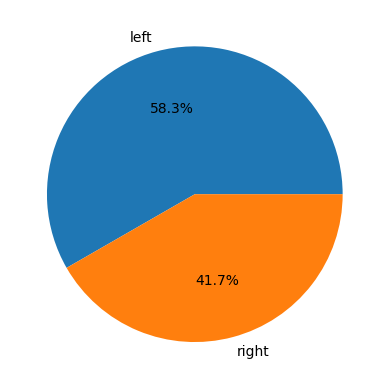

In [14]:
df.groupby("leaning", observed=True)["body_length"].sum().plot.pie(autopct="%1.1f%%", ylabel="");

Body length distribution by leaning.

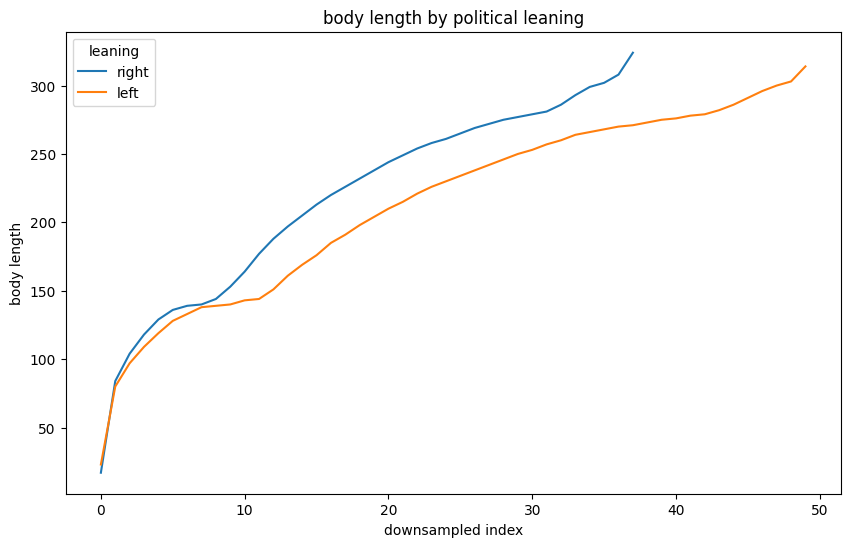

In [15]:
plt.figure(figsize=(10, 6))

for leaning in df["leaning"].unique():
    df_leaning = df[df["leaning"] == leaning]
    downsampled = pd.concat(
        # Ensuring to include the last (longest) item.
        [df_leaning["body_length"].iloc[::100], df_leaning["body_length"].tail(1)]
    ).drop_duplicates().reset_index(drop=True)
    plt.plot(downsampled, label=leaning)

plt.xlabel("downsampled index")
plt.ylabel("body length")
plt.title("body length by political leaning")
plt.legend(title="leaning")
plt.show()

In [16]:
df.to_parquet("../preprocessed/polistance_issue_tweets.parquet")